<a href="https://colab.research.google.com/github/PriyanshuRao-code/AI-Lab-Project/blob/main/team_24_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [22]:
# Don't do anything here. It's just a setup.
import os
import sys

repo_name = "AI-Lab-Project"
repo_url = "https://github.com/PriyanshuRao-code/AI-Lab-Project.git"
repo_path = f"/content/{repo_name}"

if os.path.exists(repo_path):
    print("Repository already exists at:", repo_path)
else:
    print("🚀 Cloning the repository...")
    os.system(f"git clone {repo_url}")

os.chdir(repo_path)
sys.path.append(repo_path)

print("Repository is ready to use at:", repo_path)

Repository already exists at: /content/AI-Lab-Project
Repository is ready to use at: /content/AI-Lab-Project


In [23]:
# Using supporting files (now as .ipynb and later .py)

!pip install import-ipynb
import import_ipynb
from team_24_data_preprocessing import *
from team_24_supervised_learning import *

In [24]:
df = pd.read_csv('24.csv')

In [25]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

In [26]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from scipy.stats import zscore
# from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [27]:
def x_y_separation(df_train, df_valid, df_test, target_column="Hazardous"):
  X_train = df_train.drop(columns=[target_column])
  y_train = df_train[target_column]

  X_valid = df_valid.drop(columns=[target_column])
  y_valid = df_valid[target_column]

  X_test = df_test.drop(columns=[target_column])
  y_test = df_test[target_column]

  return X_train, y_train, X_valid, y_valid, X_test, y_test

In [28]:
def remove_outliers_zscore(df_train, df_valid, df_test, z_score_threshold = 3):

  df_train_numeric = df_train.select_dtypes(include=['number']).select_dtypes(exclude=['bool'])
  df_train_non_numeric = df_train.select_dtypes(exclude=['number'])

  z_scores = df_train_numeric.apply(zscore)
  df_z = df_train_numeric[(z_scores.abs() < z_score_threshold).all(axis=1)]  # Remove rows with Z-score >  z_score_threshold in any column
  df_train_cleaned = pd.concat([df_z, df_train_non_numeric.loc[df_z.index]], axis=1)

  return df_train_cleaned, df_valid, df_test

In [29]:
def label_encode_categorical(df_train, df_valid, df_test):

  categorical_cols = df_train.select_dtypes(include=['object']).columns
  label_encoders = {}

  for col in categorical_cols:
    label_encoders[col] = LabelEncoder()
    df_train[col] = label_encoders[col].fit_transform(df_train[col])

    df_valid[col] = df_valid[col].map(lambda x: label_encoders[col].transform([x])[0] if x in label_encoders[col].classes_ else -1)
    df_test[col] = df_test[col].map(lambda x: label_encoders[col].transform([x])[0] if x in label_encoders[col].classes_ else -1)

  df_valid = df_valid[df_train.columns]
  df_test = df_test[df_train.columns]

  return df_train, df_valid, df_test

In [30]:
def standardize_data(df_train_orig, df_valid_orig, df_test_orig):
  df_train = df_train_orig.copy()
  df_valid = df_valid_orig.copy()
  df_test = df_test_orig.copy()
  scaler = StandardScaler()

  df_train_numeric = df_train.select_dtypes(include=['number']).select_dtypes(exclude=['bool'])
  df_test_numeric = df_test.select_dtypes(include=['number']).select_dtypes(exclude=['bool'])
  df_valid_numeric = df_valid.select_dtypes(include=['number']).select_dtypes(exclude=['bool'])

  # Standardization
  df_train[df_train_numeric.columns] = scaler.fit_transform(df_train_numeric)
  df_test[df_test_numeric.columns] = scaler.transform(df_test_numeric)
  df_valid[df_valid_numeric.columns] = scaler.transform(df_valid_numeric)

  return df_train, df_valid, df_test

In [31]:
def remove_highly_correlated(df_train, df_valid, df_test, high_corr_threshold = 0.99):

  df_train_numeric = df_train.select_dtypes(include=['number']).select_dtypes(exclude=['bool'])

  high_corr_pairs = set()
  correlation_matrix = df_train_numeric.corr()

  for i in range(len(correlation_matrix.columns)):
    for j in range(i): # Lower triangular matrix
      if abs(correlation_matrix.iloc[i, j]) >= high_corr_threshold:
        col1 = correlation_matrix.columns[i]
        col2 = correlation_matrix.columns[j]
        high_corr_pairs.add((col1, col2))

  columns_to_drop = {col2 for col1, col2 in high_corr_pairs}

  df_train_reduced = df_train.drop(columns=columns_to_drop)
  df_valid_reduced = df_valid.drop(columns=columns_to_drop)
  df_test_reduced = df_test.drop(columns=columns_to_drop)

  return df_train_reduced, df_valid_reduced, df_test_reduced

In [32]:
def perform_pca(df_train, df_valid, df_test, target_col="Hazardous", n_components=3):

  # Split features & target
  X_train = df_train.drop(columns=[target_col])
  X_valid = df_valid.drop(columns=[target_col])
  X_test  = df_test.drop(columns=[target_col])

  y_train = df_train[target_col].reset_index(drop=True)
  y_valid = df_valid[target_col].reset_index(drop=True)
  y_test  = df_test[target_col].reset_index(drop=True)

  # PCA
  pca = PCA(n_components=n_components)
  pca.fit(X_train)

  X_train_pca = pd.DataFrame(pca.transform(X_train), columns=[f'PC{i+1}' for i in range(n_components)])
  X_valid_pca = pd.DataFrame(pca.transform(X_valid), columns=[f'PC{i+1}' for i in range(n_components)])
  X_test_pca  = pd.DataFrame(pca.transform(X_test),  columns=[f'PC{i+1}' for i in range(n_components)])

  # Add target back
  df_train_pca = pd.concat([X_train_pca, y_train], axis=1)
  df_valid_pca = pd.concat([X_valid_pca, y_valid], axis=1)
  df_test_pca  = pd.concat([X_test_pca,  y_test],  axis=1)

  return df_train_pca, df_valid_pca, df_test_pca

In [33]:
class Perceptron(nn.Module):
    def __init__(self, input_dim):
        super(Perceptron, self).__init__()
        self.fc1 = nn.Linear(input_dim, 8)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(8, 1)  # Output Layer

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

In [34]:
def train_model_perceptron(df_train, df_valid, df_test, target_column = "Hazardous", num_epochs=2000, lr=0.0001):

  # Each time it may have different accuracy, recall due to ->  Weight Initialization of Perceptron is Random
  X_train, y_train, X_valid, y_valid, X_test, y_test = x_y_separation(df_train, df_valid, df_test)

  X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
  X_valid_tensor = torch.tensor(X_valid.values, dtype=torch.float32)
  X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)

  y_train_tensor = torch.tensor(y_train.values.reshape(-1, 1), dtype=torch.float32)
  y_valid_tensor = torch.tensor(y_valid.values.reshape(-1, 1), dtype=torch.float32)
  y_test_tensor = torch.tensor(y_test.values.reshape(-1, 1), dtype=torch.float32)


  perceptron_model = Perceptron(X_train_tensor.shape[1])

  criterion = nn.BCEWithLogitsLoss()
  optimizer = optim.SGD(perceptron_model.parameters(), lr=lr)

  for epoch in range(num_epochs):
    optimizer.zero_grad()
    outputs = perceptron_model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()

    # if epoch % 10 == 0:
    #   print(f"Epoch {epoch}, Loss: {loss.item()}")

  with torch.no_grad():
    y_valid_pred_nn = perceptron_model(X_valid_tensor).sigmoid().round()
    y_test_pred_nn = perceptron_model(X_test_tensor).sigmoid().round()

    # Convert tensors to numpy
    y_valid_pred_nn = y_valid_pred_nn.detach().numpy()
    y_test_pred_nn = y_test_pred_nn.detach().numpy()

    # Convert y_valid, y_test to numpy for evaluation
    y_valid_numpy = y_valid_tensor.detach().numpy()
    y_test_numpy = y_test_tensor.detach().numpy()

  return perceptron_model, y_valid_numpy, y_test_numpy, y_valid_pred_nn, y_test_pred_nn

In [35]:
# def train_model_random_forest(df_train, df_valid, df_test, target_column="Hazardous"):

#     X_train, y_train, X_valid, y_valid, X_test, y_test = x_y_separation(df_train, df_valid, df_test)

#     X_train_rf = np.array(X_train)
#     X_valid_rf = np.array(X_valid)
#     X_test_rf = np.array(X_test)

#     y_train_rf = np.array(y_train)
#     y_valid_rf = np.array(y_valid)
#     y_test_rf = np.array(y_test)

#     random_forest = RandomForestClassifier(n_estimators=100, random_state=42)
#     random_forest.fit(X_train_rf, y_train_rf)

#     y_valid_pred_rf = random_forest.predict(X_valid_rf)
#     y_test_pred_rf = random_forest.predict(X_test_rf)

#     return random_forest, y_valid_rf, y_test_rf, y_valid_pred_rf, y_test_pred_rf

In [36]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, classification_report

def evaluate_model(y_true, y_pred, model_name="Model", return_metrics=False):
    print(f"\nEvaluation Metrics for {model_name}:")
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap='coolwarm', xticklabels=["Not Hazardous", "Hazardous"], yticklabels=["Not Hazardous", "Hazardous"])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"{model_name} Confusion Matrix")
    plt.show()
    accuracy = accuracy_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    print(f"\n=== Evaluation Report for {model_name} ===")
    print(f"Accuracy : {accuracy:.4f}")
    print(f"Recall   : {recall:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"F1 Score : {f1:.4f}")
    print("\nClassification Report:\n", classification_report(y_true, y_pred))

    if return_metrics:
        return {
            'accuracy': accuracy,
            'recall': recall,
            'precision': precision,
            'f1_score': f1
        }

In [37]:
df_train_full, df_temp = train_test_split(df, test_size=0.3, random_state=42, stratify=df['Hazardous'])
df_valid, df_test = train_test_split(df_temp, test_size=0.5, random_state=42, stratify=df_temp['Hazardous'])

In [38]:
df_train, df_valid, df_test = remove_outliers_zscore(df_train_full, df_valid, df_test)

In [39]:
df_train, df_valid, df_test = label_encode_categorical(df_train, df_valid, df_test)

In [40]:
df_train, df_valid, df_test = remove_highly_correlated(df_train, df_valid, df_test)

In [41]:
df_train, df_valid, df_test = standardize_data(df_train, df_valid, df_test)


===== Perceptron with PCA (n_components=1) =====

Evaluation Metrics for Perceptron with PCA-1:


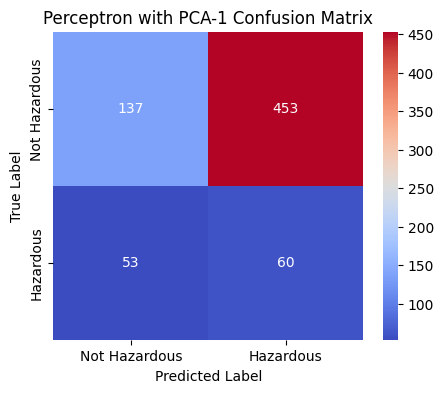


=== Evaluation Report for Perceptron with PCA-1 ===
Accuracy : 0.2802
Recall   : 0.5310
Precision: 0.1170
F1 Score : 0.1917

Classification Report:
               precision    recall  f1-score   support

         0.0       0.72      0.23      0.35       590
         1.0       0.12      0.53      0.19       113

    accuracy                           0.28       703
   macro avg       0.42      0.38      0.27       703
weighted avg       0.62      0.28      0.33       703


===== Perceptron with PCA (n_components=2) =====

Evaluation Metrics for Perceptron with PCA-2:


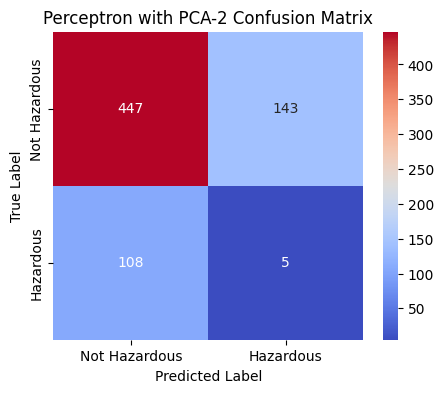


=== Evaluation Report for Perceptron with PCA-2 ===
Accuracy : 0.6430
Recall   : 0.0442
Precision: 0.0338
F1 Score : 0.0383

Classification Report:
               precision    recall  f1-score   support

         0.0       0.81      0.76      0.78       590
         1.0       0.03      0.04      0.04       113

    accuracy                           0.64       703
   macro avg       0.42      0.40      0.41       703
weighted avg       0.68      0.64      0.66       703


===== Perceptron with PCA (n_components=3) =====

Evaluation Metrics for Perceptron with PCA-3:


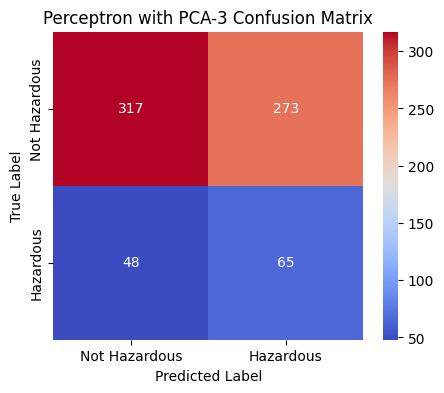


=== Evaluation Report for Perceptron with PCA-3 ===
Accuracy : 0.5434
Recall   : 0.5752
Precision: 0.1923
F1 Score : 0.2882

Classification Report:
               precision    recall  f1-score   support

         0.0       0.87      0.54      0.66       590
         1.0       0.19      0.58      0.29       113

    accuracy                           0.54       703
   macro avg       0.53      0.56      0.48       703
weighted avg       0.76      0.54      0.60       703


===== Perceptron with PCA (n_components=4) =====

Evaluation Metrics for Perceptron with PCA-4:


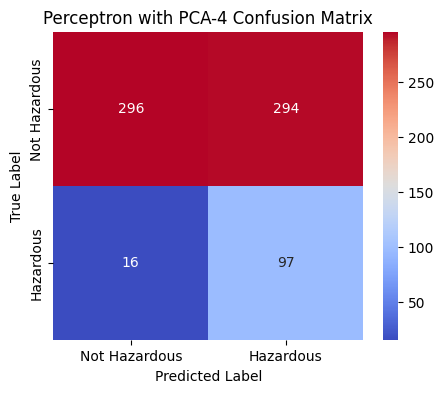


=== Evaluation Report for Perceptron with PCA-4 ===
Accuracy : 0.5590
Recall   : 0.8584
Precision: 0.2481
F1 Score : 0.3849

Classification Report:
               precision    recall  f1-score   support

         0.0       0.95      0.50      0.66       590
         1.0       0.25      0.86      0.38       113

    accuracy                           0.56       703
   macro avg       0.60      0.68      0.52       703
weighted avg       0.84      0.56      0.61       703


===== Perceptron with PCA (n_components=5) =====

Evaluation Metrics for Perceptron with PCA-5:


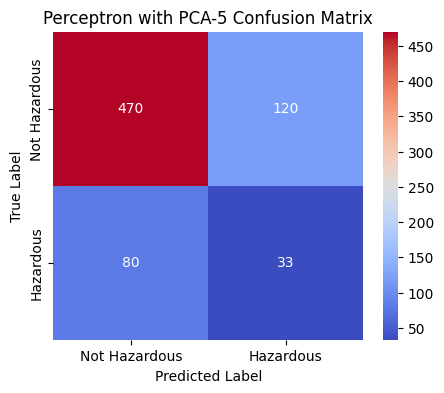


=== Evaluation Report for Perceptron with PCA-5 ===
Accuracy : 0.7155
Recall   : 0.2920
Precision: 0.2157
F1 Score : 0.2481

Classification Report:
               precision    recall  f1-score   support

         0.0       0.85      0.80      0.82       590
         1.0       0.22      0.29      0.25       113

    accuracy                           0.72       703
   macro avg       0.54      0.54      0.54       703
weighted avg       0.75      0.72      0.73       703


===== Perceptron with PCA (n_components=6) =====

Evaluation Metrics for Perceptron with PCA-6:


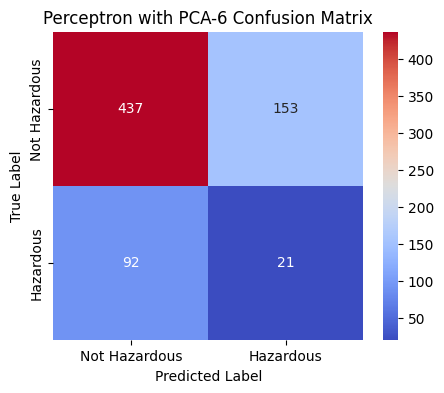


=== Evaluation Report for Perceptron with PCA-6 ===
Accuracy : 0.6515
Recall   : 0.1858
Precision: 0.1207
F1 Score : 0.1463

Classification Report:
               precision    recall  f1-score   support

         0.0       0.83      0.74      0.78       590
         1.0       0.12      0.19      0.15       113

    accuracy                           0.65       703
   macro avg       0.47      0.46      0.46       703
weighted avg       0.71      0.65      0.68       703


===== Perceptron with PCA (n_components=7) =====

Evaluation Metrics for Perceptron with PCA-7:


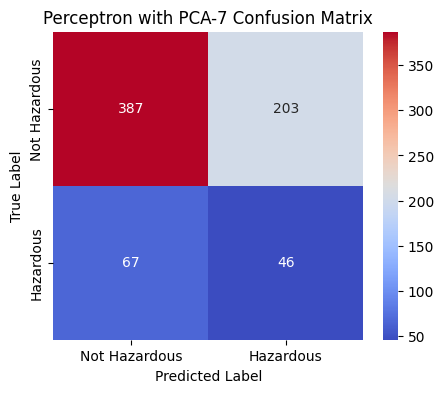


=== Evaluation Report for Perceptron with PCA-7 ===
Accuracy : 0.6159
Recall   : 0.4071
Precision: 0.1847
F1 Score : 0.2541

Classification Report:
               precision    recall  f1-score   support

         0.0       0.85      0.66      0.74       590
         1.0       0.18      0.41      0.25       113

    accuracy                           0.62       703
   macro avg       0.52      0.53      0.50       703
weighted avg       0.75      0.62      0.66       703


===== Perceptron with PCA (n_components=8) =====

Evaluation Metrics for Perceptron with PCA-8:


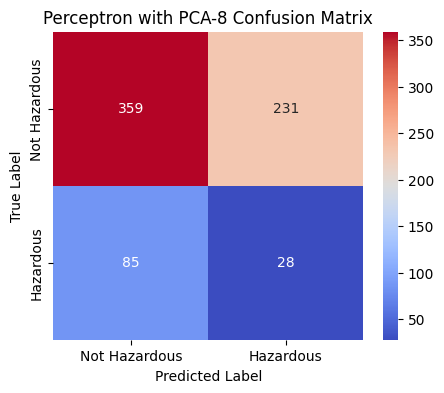


=== Evaluation Report for Perceptron with PCA-8 ===
Accuracy : 0.5505
Recall   : 0.2478
Precision: 0.1081
F1 Score : 0.1505

Classification Report:
               precision    recall  f1-score   support

         0.0       0.81      0.61      0.69       590
         1.0       0.11      0.25      0.15       113

    accuracy                           0.55       703
   macro avg       0.46      0.43      0.42       703
weighted avg       0.70      0.55      0.61       703


===== Perceptron with PCA (n_components=9) =====

Evaluation Metrics for Perceptron with PCA-9:


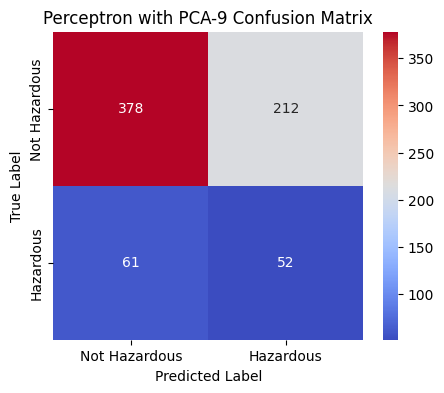


=== Evaluation Report for Perceptron with PCA-9 ===
Accuracy : 0.6117
Recall   : 0.4602
Precision: 0.1970
F1 Score : 0.2759

Classification Report:
               precision    recall  f1-score   support

         0.0       0.86      0.64      0.73       590
         1.0       0.20      0.46      0.28       113

    accuracy                           0.61       703
   macro avg       0.53      0.55      0.51       703
weighted avg       0.75      0.61      0.66       703


===== Perceptron with PCA (n_components=10) =====

Evaluation Metrics for Perceptron with PCA-10:


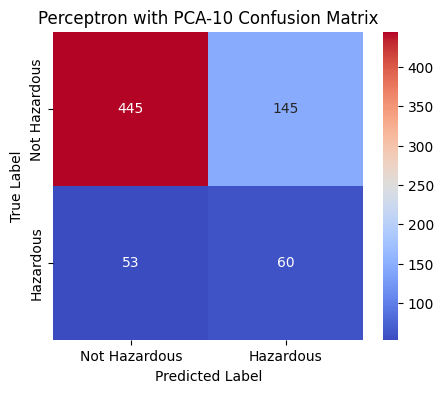


=== Evaluation Report for Perceptron with PCA-10 ===
Accuracy : 0.7183
Recall   : 0.5310
Precision: 0.2927
F1 Score : 0.3774

Classification Report:
               precision    recall  f1-score   support

         0.0       0.89      0.75      0.82       590
         1.0       0.29      0.53      0.38       113

    accuracy                           0.72       703
   macro avg       0.59      0.64      0.60       703
weighted avg       0.80      0.72      0.75       703


===== Perceptron with PCA (n_components=11) =====

Evaluation Metrics for Perceptron with PCA-11:


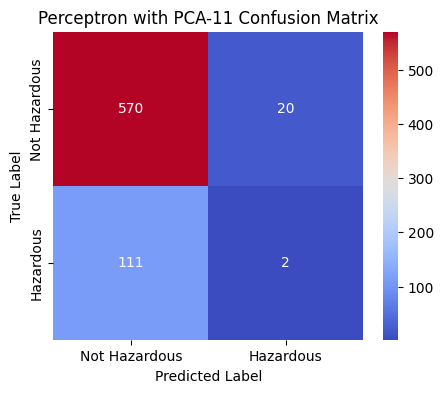


=== Evaluation Report for Perceptron with PCA-11 ===
Accuracy : 0.8137
Recall   : 0.0177
Precision: 0.0909
F1 Score : 0.0296

Classification Report:
               precision    recall  f1-score   support

         0.0       0.84      0.97      0.90       590
         1.0       0.09      0.02      0.03       113

    accuracy                           0.81       703
   macro avg       0.46      0.49      0.46       703
weighted avg       0.72      0.81      0.76       703


===== Perceptron with PCA (n_components=12) =====

Evaluation Metrics for Perceptron with PCA-12:


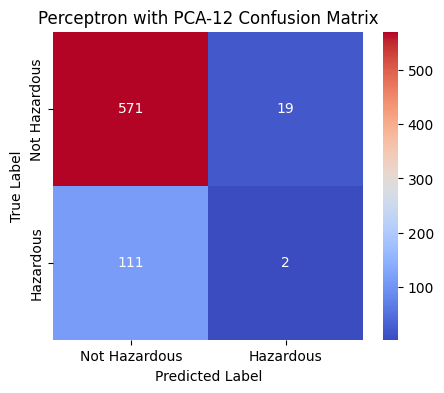


=== Evaluation Report for Perceptron with PCA-12 ===
Accuracy : 0.8151
Recall   : 0.0177
Precision: 0.0952
F1 Score : 0.0299

Classification Report:
               precision    recall  f1-score   support

         0.0       0.84      0.97      0.90       590
         1.0       0.10      0.02      0.03       113

    accuracy                           0.82       703
   macro avg       0.47      0.49      0.46       703
weighted avg       0.72      0.82      0.76       703


===== Perceptron with PCA (n_components=13) =====

Evaluation Metrics for Perceptron with PCA-13:


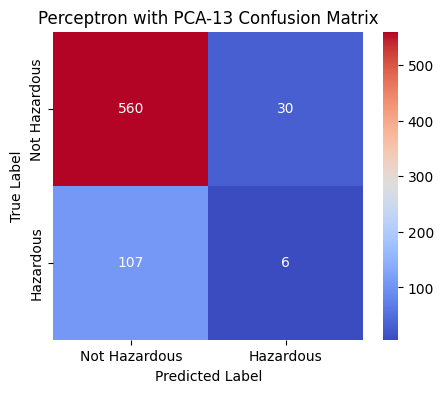


=== Evaluation Report for Perceptron with PCA-13 ===
Accuracy : 0.8051
Recall   : 0.0531
Precision: 0.1667
F1 Score : 0.0805

Classification Report:
               precision    recall  f1-score   support

         0.0       0.84      0.95      0.89       590
         1.0       0.17      0.05      0.08       113

    accuracy                           0.81       703
   macro avg       0.50      0.50      0.49       703
weighted avg       0.73      0.81      0.76       703


===== Perceptron with PCA (n_components=14) =====

Evaluation Metrics for Perceptron with PCA-14:


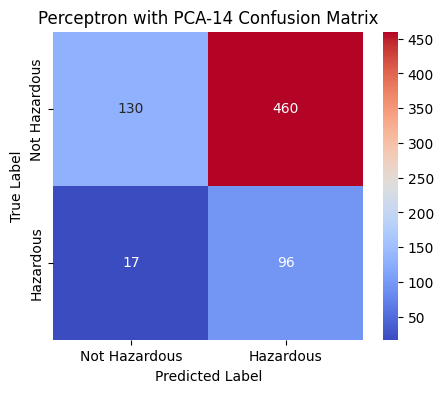


=== Evaluation Report for Perceptron with PCA-14 ===
Accuracy : 0.3215
Recall   : 0.8496
Precision: 0.1727
F1 Score : 0.2870

Classification Report:
               precision    recall  f1-score   support

         0.0       0.88      0.22      0.35       590
         1.0       0.17      0.85      0.29       113

    accuracy                           0.32       703
   macro avg       0.53      0.53      0.32       703
weighted avg       0.77      0.32      0.34       703


===== Perceptron with PCA (n_components=15) =====

Evaluation Metrics for Perceptron with PCA-15:


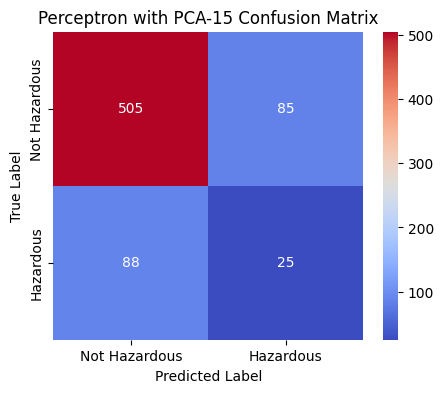


=== Evaluation Report for Perceptron with PCA-15 ===
Accuracy : 0.7539
Recall   : 0.2212
Precision: 0.2273
F1 Score : 0.2242

Classification Report:
               precision    recall  f1-score   support

         0.0       0.85      0.86      0.85       590
         1.0       0.23      0.22      0.22       113

    accuracy                           0.75       703
   macro avg       0.54      0.54      0.54       703
weighted avg       0.75      0.75      0.75       703


===== Perceptron with PCA (n_components=16) =====

Evaluation Metrics for Perceptron with PCA-16:


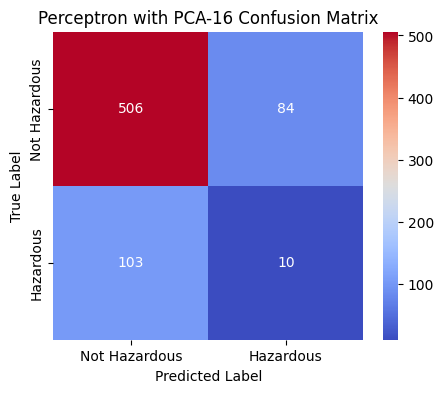


=== Evaluation Report for Perceptron with PCA-16 ===
Accuracy : 0.7340
Recall   : 0.0885
Precision: 0.1064
F1 Score : 0.0966

Classification Report:
               precision    recall  f1-score   support

         0.0       0.83      0.86      0.84       590
         1.0       0.11      0.09      0.10       113

    accuracy                           0.73       703
   macro avg       0.47      0.47      0.47       703
weighted avg       0.71      0.73      0.72       703


===== Perceptron with PCA (n_components=17) =====

Evaluation Metrics for Perceptron with PCA-17:


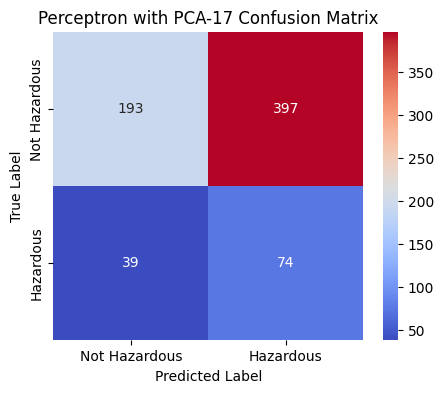


=== Evaluation Report for Perceptron with PCA-17 ===
Accuracy : 0.3798
Recall   : 0.6549
Precision: 0.1571
F1 Score : 0.2534

Classification Report:
               precision    recall  f1-score   support

         0.0       0.83      0.33      0.47       590
         1.0       0.16      0.65      0.25       113

    accuracy                           0.38       703
   macro avg       0.49      0.49      0.36       703
weighted avg       0.72      0.38      0.43       703


===== Perceptron with PCA (n_components=18) =====

Evaluation Metrics for Perceptron with PCA-18:


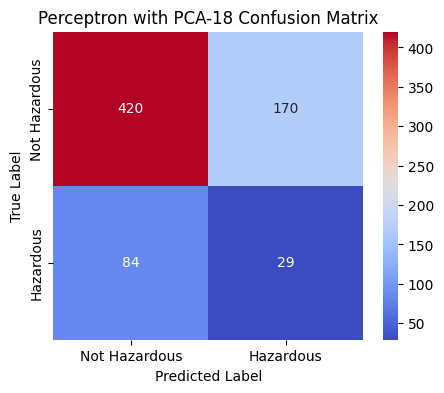


=== Evaluation Report for Perceptron with PCA-18 ===
Accuracy : 0.6387
Recall   : 0.2566
Precision: 0.1457
F1 Score : 0.1859

Classification Report:
               precision    recall  f1-score   support

         0.0       0.83      0.71      0.77       590
         1.0       0.15      0.26      0.19       113

    accuracy                           0.64       703
   macro avg       0.49      0.48      0.48       703
weighted avg       0.72      0.64      0.67       703


===== Perceptron with PCA (n_components=19) =====

Evaluation Metrics for Perceptron with PCA-19:


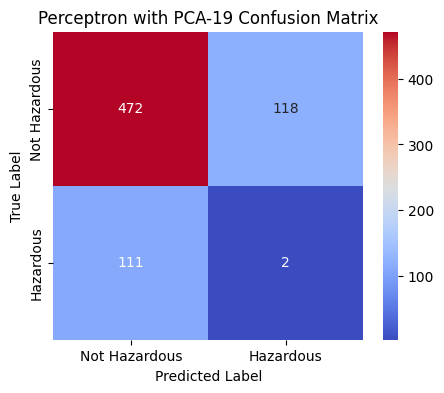


=== Evaluation Report for Perceptron with PCA-19 ===
Accuracy : 0.6743
Recall   : 0.0177
Precision: 0.0167
F1 Score : 0.0172

Classification Report:
               precision    recall  f1-score   support

         0.0       0.81      0.80      0.80       590
         1.0       0.02      0.02      0.02       113

    accuracy                           0.67       703
   macro avg       0.41      0.41      0.41       703
weighted avg       0.68      0.67      0.68       703


===== Perceptron with PCA (n_components=20) =====

Evaluation Metrics for Perceptron with PCA-20:


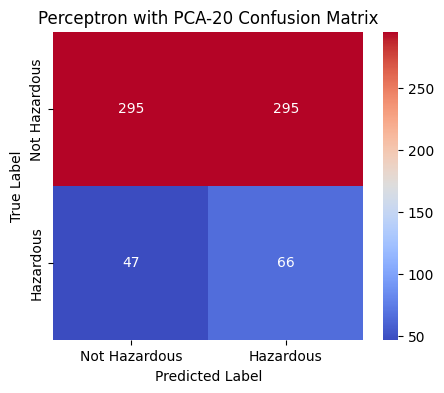


=== Evaluation Report for Perceptron with PCA-20 ===
Accuracy : 0.5135
Recall   : 0.5841
Precision: 0.1828
F1 Score : 0.2785

Classification Report:
               precision    recall  f1-score   support

         0.0       0.86      0.50      0.63       590
         1.0       0.18      0.58      0.28       113

    accuracy                           0.51       703
   macro avg       0.52      0.54      0.46       703
weighted avg       0.75      0.51      0.58       703


===== Perceptron with PCA (n_components=21) =====

Evaluation Metrics for Perceptron with PCA-21:


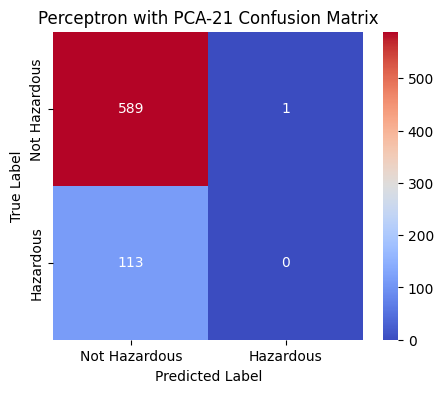


=== Evaluation Report for Perceptron with PCA-21 ===
Accuracy : 0.8378
Recall   : 0.0000
Precision: 0.0000
F1 Score : 0.0000

Classification Report:
               precision    recall  f1-score   support

         0.0       0.84      1.00      0.91       590
         1.0       0.00      0.00      0.00       113

    accuracy                           0.84       703
   macro avg       0.42      0.50      0.46       703
weighted avg       0.70      0.84      0.77       703


===== Perceptron with PCA (n_components=22) =====

Evaluation Metrics for Perceptron with PCA-22:


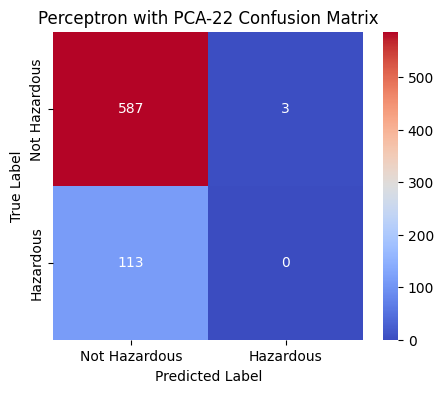


=== Evaluation Report for Perceptron with PCA-22 ===
Accuracy : 0.8350
Recall   : 0.0000
Precision: 0.0000
F1 Score : 0.0000

Classification Report:
               precision    recall  f1-score   support

         0.0       0.84      0.99      0.91       590
         1.0       0.00      0.00      0.00       113

    accuracy                           0.83       703
   macro avg       0.42      0.50      0.46       703
weighted avg       0.70      0.83      0.76       703


===== Perceptron with PCA (n_components=23) =====

Evaluation Metrics for Perceptron with PCA-23:


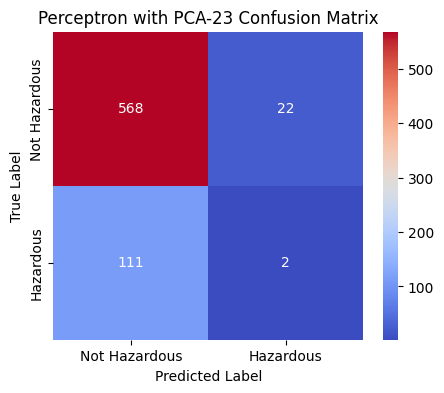


=== Evaluation Report for Perceptron with PCA-23 ===
Accuracy : 0.8108
Recall   : 0.0177
Precision: 0.0833
F1 Score : 0.0292

Classification Report:
               precision    recall  f1-score   support

         0.0       0.84      0.96      0.90       590
         1.0       0.08      0.02      0.03       113

    accuracy                           0.81       703
   macro avg       0.46      0.49      0.46       703
weighted avg       0.72      0.81      0.76       703



In [42]:
metrics_summary = []

for n_components in range(1, min(len(df_train.columns), 35)):  # prevent PCA n_components from exceeding feature count
    print(f"\n===== Perceptron with PCA (n_components={n_components}) =====")

    df_train_pca, df_valid_pca, df_test_pca = perform_pca(df_train, df_valid, df_test, n_components=n_components)
    model, y_valid_true, y_test_true, y_valid_pred, y_test_pred = train_model_perceptron(
        df_train_pca, df_valid_pca, df_test_pca
    )

    metrics = evaluate_model(y_valid_true, y_valid_pred, model_name=f"Perceptron with PCA-{n_components}", return_metrics=True)

    metrics_summary.append({
        'n_components': n_components,
        'accuracy': metrics['accuracy'],
        'recall': metrics['recall'],
        'precision': metrics['precision'],
        'f1_score': metrics['f1_score']
    })

In [43]:
metrics_df = pd.DataFrame(metrics_summary)

best_accuracy_pca = metrics_df.loc[metrics_df['accuracy'].idxmax(), 'n_components']
best_recall_pca = metrics_df.loc[metrics_df['recall'].idxmax(), 'n_components']
best_precision_pca = metrics_df.loc[metrics_df['precision'].idxmax(), 'n_components']
best_f1_pca = metrics_df.loc[metrics_df['f1_score'].idxmax(), 'n_components']

print("\n========= Best PCA Results =========")
print(f"Highest Accuracy: PCA Components = {best_accuracy_pca}")
print(f"Highest Recall: PCA Components = {best_recall_pca}")
print(f"Highest Precision: PCA Components = {best_precision_pca}")
print(f"Highest F1-Score: PCA Components = {best_f1_pca}")


========= Best PCA Results =========
Highest Accuracy: PCA Components = 21
Highest Recall: PCA Components = 4
Highest Precision: PCA Components = 10
Highest F1-Score: PCA Components = 4
